# EDA for Journals Recommendation Engine 

### Import Libraries

In [2]:
import pickle
import json
import dask.bag as db
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
import re
from collections import Counter
from matplotlib import gridspec
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
data = db.read_text('arxiv-metadata-oai-snapshot.json').map(json.loads)


In [3]:
# Total number of research paper in the dataset
data.count().compute()


2100683

In [4]:
# First record from dataset
data.take(1)


({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

In [5]:
getLatestVersion = lambda x : x ['versions'][-1]['created']
dates = (data.map(getLatestVersion).frequencies(sort = True))


In [6]:
# show top submissions datetime
(dates.topk(10, key=1).compute())


[('Wed, 27 Jun 2012 19:59:59 GMT', 103),
 ('Tue, 14 Feb 2012 16:41:17 GMT', 82),
 ('Thu, 15 Mar 2012 11:17:56 GMT', 78),
 ('Sun, 1 Dec 2002 00:00:00 GMT', 35),
 ('Thu, 1 Jul 1999 00:00:00 GMT', 22),
 ('Wed, 1 Apr 1992 00:00:00 GMT', 22),
 ('Wed, 8 Apr 1992 22:58:34 GMT', 18),
 ('Thu, 9 Feb 1995 00:00:00 GMT', 18),
 ('Wed, 1 Jan 1992 00:00:00 GMT', 17),
 ('Fri, 9 Jul 1993 00:00:00 GMT', 17)]

In [7]:
# get only necessary fields
trim = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract']}
# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract']
docs_df = (data
             .filter(lambda x: int(getLatestVersion(x).split(' ')[3]) > 2020)
             .map(trim)
             .compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

# add general category. we are going to use as our target variable
docs_df['general_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x])

In [8]:
# add general category. we are going to use as our target variable
docs_df['general_category'] = docs_df.category.apply(lambda x:','.join({a.split('.')[0] for a in x}))
# Modified Category 
docs_df['category'] = docs_df.category.apply(lambda x : ','.join({ ' '.join(i.split('.')[1:]) for i in x}))



In [9]:
docs_df['length_of_title'] = docs_df.title.apply(lambda title : len(title.split() if len(title)>0 else 0))
docs_df['length_of_abstract'] = docs_df.abstract.apply(lambda abstract : len(abstract.split()) if len(abstract)>0 else 0)
docs_df['no_of_general_category_per_paper'] = docs_df.general_category.apply(lambda gc : len(gc.split(',')) if len(gc) > 0 else 0)
docs_df['no_of_category_per_paper'] = docs_df.category.apply(lambda gc : len(gc.split(',')) if len(gc) > 0 else 0)


## Extracted Research Paper Dataset after Year 2020
1. It has 5 columns, all columns has it own importance to build Journal Recommendation Engine.
2. In order to build RecSys we will use 'title' and 'abstract' of the Research paper.
3. Dataset consist 336303 research papers after 2020 belong from various category.

In [10]:
docs_df.head()

,id,title,category,abstract,general_category,length_of_title,length_of_abstract,no_of_general_category_per_paper,no_of_category_per_paper
0,0704.0033,Convergence of the discrete dipole approximati...,"comp-ph,optics",We performed a rigorous theoretical converge...,physics,9,133,1,2
1,0704.0038,The discrete dipole approximation: an overview...,"comp-ph,optics",We present a review of the discrete dipole a...,physics,9,96,1,2
2,0704.0479,The affine part of the Picard scheme,"KT,AG",We describe the maximal torus and maximal un...,math,7,21,1,2
3,0705.3841,Renormalization Group Evolution in the type I ...,,We carefully analyze the renormalization gro...,hep-ph,11,95,1,0
4,0705.4060,C*- Algebras and Thermodynamic Formalism,"OA,DS",We present a detailed exposition (for a Dyna...,math,5,110,1,2


In [11]:
len(docs_df.category[3].split(','))

1

In [12]:
print(f'The shape of the research paper dataset which are published after 2020 is {docs_df.shape}')

The shape of the research paper dataset which are published after 2020 is (336303, 9)


### Some usefull insights form Title, Abstract, General Category and Sub-Category
#### Title
1. Title word count of 75% of papers is 12 word per article.
2. Maximum word count for Title is 43 words and minimum is 1 word.
3. We can see there're 3 duplicate Title with unique ID.

#### Abstract
1. Word count for abstract for 74% of research paper is 198 word per article.
2. Maximum word count for abstract is 498 words and minimum is 3 words.
3. We also have 2 duplicate abstract in our dataset.

#### General Category
1. 75% of papers belongs from atmost 2 general categories.
2. Maximum number of general category per artical is 6 and minimum is 1.
3. Maximum article belongs from 'CS' category that is 83632 since year 2021.

#### Category (Sub-Category)
1. 75% of papers belongs from atmost 2 sub categories.
2. Maximum number of sub-category per artical is 8 and minimum is 0.
3. We've 29492 articals which sub-category is untagged.

#### Note : We'll use these usefull insight for data preprocessing.


In [13]:
docs_df.describe()

,length_of_title,length_of_abstract,no_of_general_category_per_paper,no_of_category_per_paper
count,336303.000000,336303.000000,336303.000000,336303.000000
mean,9.875466,156.812526,1.433764,1.654609
std,3.656913,59.967704,0.693900,1.015316
min,1.000000,3.000000,1.000000,0.000000
25%,7.000000,114.000000,1.000000,1.000000
50%,9.000000,155.000000,1.000000,2.000000
75%,12.000000,198.000000,2.000000,2.000000
max,43.000000,498.000000,6.000000,8.000000


In [14]:
docs_df[docs_df.columns[:5]].describe()

,id,title,category,abstract,general_category
count,336303,336303,336303,336303,336303
unique,336303,336162,17423,336253,1213
top,0704.0033,The LHCspin project,,We compute numerically the reheating tempera...,cs
freq,1,3,29492,2,83632


### Number of artical which Sub-Category is not taged .
* We've 29492 artical which sub-category is not tagged.
* Sub-Category is an important feature for building recommendation system or for claasification problem.
* We'll drop untagged sub-category from journals dataset.

In [15]:
untagged_sub_cat_idx = docs_df[docs_df.no_of_category_per_paper <1].index
docs_df = docs_df.drop(untagged_sub_cat_idx)

In [16]:
print(untagged_sub_cat_idx.shape)
print(docs_df.shape)

(29492,)
(306811, 9)


### Duplicate Title and Abstract
* We'll drop those artical which has duplicate Title and Abstract.


In [17]:
docs_df = docs_df.drop_duplicates(subset=['title'])
docs_df = docs_df.drop_duplicates(subset=['abstract'])

### Number of articals which Title and Abstract word count is greater then equal to maximum word count
* PDFs of Abstract and Title are in Gaussion Distribution. 
* There is only 1 artical which Title length is greater and equal to 43 words per artical and 1 for Abstract which Abstract word length is > equal to 498.
* We'll not drop Title which word length is >= 43 because it will not impact during traing.

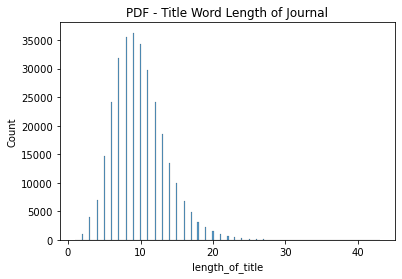

In [18]:
ax = sns.histplot(docs_df.length_of_title)
plt.title("PDF - Title Word Length of Journal")
plt.show()

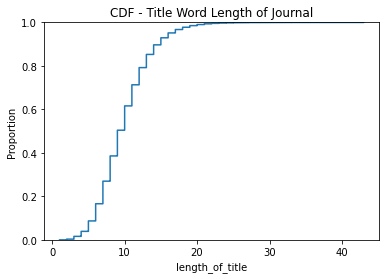

In [19]:
sns.ecdfplot(data=docs_df, x="length_of_title")
plt.title("CDF - Title Word Length of Journal")
plt.show()

In [20]:
docs_df[docs_df.length_of_title >=43]

,id,title,category,abstract,general_category,length_of_title,length_of_abstract,no_of_general_category_per_paper,no_of_category_per_paper
261692,2202.13233,Weakly-bound clusters of atmospheric molecules...,atm-clus,Structural calculations and high-resolution ...,physics,43,203,1,1


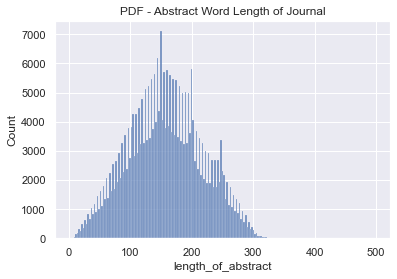

In [21]:
sns.set_theme()
ax = sns.histplot(docs_df.length_of_abstract)
plt.title("PDF - Abstract Word Length of Journal")
plt.show()

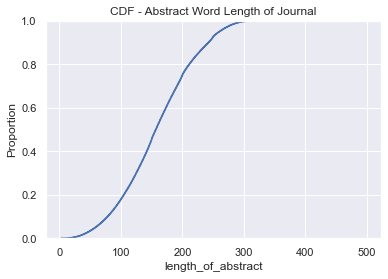

In [22]:
sns.ecdfplot(data=docs_df, x="length_of_abstract")
plt.title("CDF - Abstract Word Length of Journal")
plt.show()

In [23]:
docs_df[(docs_df.length_of_abstract <498) & (docs_df.length_of_abstract > 450) ]

,id,title,category,abstract,general_category,length_of_title,length_of_abstract,no_of_general_category_per_paper,no_of_category_per_paper
257690,2202.09231,Debootstrapping without Archeology: Stacked Im...,PL,Context: It is common for programming langua...,cs,7,464,1,1
324661,2206.14606,Building a Secure Software Supply Chain with G...,"PL,SE",The software supply chain is becoming a wide...,cs,9,487,1,2


## Unique General Categories
* We have 20 unique general category in our dataset
* As we know that per artical can be categorized more then one unique gereral categories.
* Encoded the General category into bit format 0 and 1 form.
* Merged artical datafame with Multi-label general category. 

In [24]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(docs_df.general_category.apply(lambda x : x.split(',')))
unique_general_categories = mlb.classes_

In [25]:
print(unique_general_categories)

['astro-ph' 'cond-mat' 'cs' 'econ' 'eess' 'gr-qc' 'hep-ex' 'hep-lat'
 'hep-ph' 'hep-th' 'math' 'math-ph' 'nlin' 'nucl-ex' 'nucl-th' 'physics'
 'q-bio' 'q-fin' 'quant-ph' 'stat']


In [26]:
docs_df[unique_general_categories] = labels

In [27]:
docs_df.head(2)

,id,title,category,abstract,general_category,length_of_title,length_of_abstract,no_of_general_category_per_paper,no_of_category_per_paper,astro-ph,...,math,math-ph,nlin,nucl-ex,nucl-th,physics,q-bio,q-fin,quant-ph,stat
0,0704.0033,Convergence of the discrete dipole approximati...,"comp-ph,optics",We performed a rigorous theoretical converge...,physics,9,133,1,2,0,...,0,0,0,0,0,1,0,0,0,0
1,0704.0038,The discrete dipole approximation: an overview...,"comp-ph,optics",We present a review of the discrete dipole a...,physics,9,96,1,2,0,...,0,0,0,0,0,1,0,0,0,0


In [168]:
docs_df.to_csv('journal-resSys-dataset.csv')

NameError: name 'docs_df' is not defined

In [169]:
df = pd.read_csv('journal-resSys-dataset.csv')

/var/folders/7x/sqswkg891lg038zn9b1jw7jr0000gn/T/ipykernel_45639/4135611234.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('journal-resSys-dataset.csv')


In [170]:
pd.DataFrame({'title': df.title, 'abstract':df.abstract}).to_csv('journal-title-abstract.csv')

In [171]:
pd.DataFrame({'title': df.title}).to_csv('journal-title.csv')

In [172]:
pd.DataFrame({'abstract': df.abstract}).to_csv('journal-abstract.csv')

## Principal Components of the Title TF-IDF Matrix by Category

In [29]:
docs_df_50k = docs_df.sample(n = 50000)

In [30]:
docs_df_50k.shape

(50000, 29)

In [32]:
title_vectorizer_tfidf = TfidfVectorizer(stop_words=stop_words).fit_transform(docs_df_50k.title.values).todense()

In [33]:
pca = PCA(n_components=2).fit(title_vectorizer_tfidf)

/Users/prateeksahu/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [38]:
data2D = pd.DataFrame(pca.transform(title_vectorizer_tfidf), columns = ['PC1','PC2'])

/Users/prateeksahu/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [43]:
color = docs_df_50k.iloc[:,9:].apply(lambda x: x.index[x>0][0], axis = 1)
data2D['category'] = color.to_list()

In [55]:
pickle.dump(pca, open("pca.pickle","wb"))

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

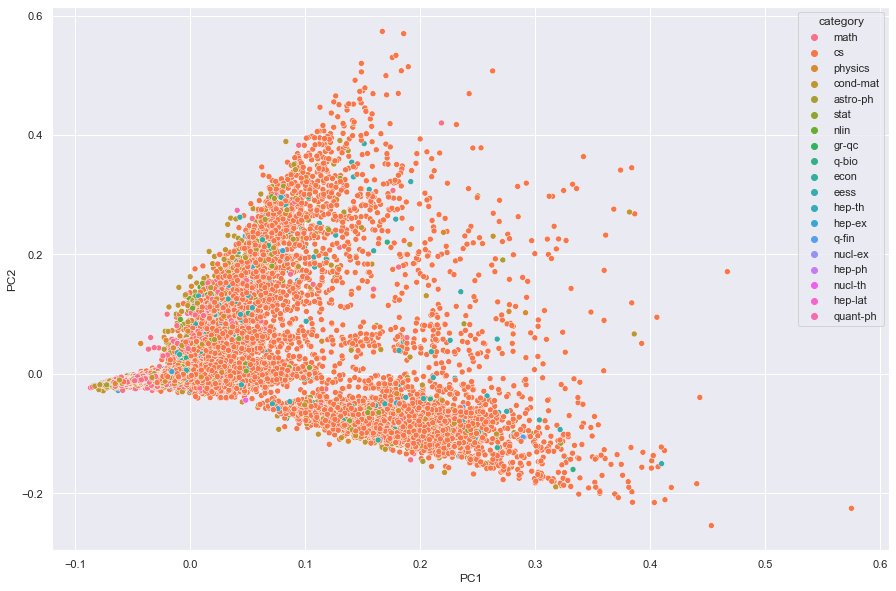

In [53]:
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(data=data2D , x='PC1', y='PC2' ,hue='category')

## Text Preprocessing

In [3]:
journal_data = pd.read_csv('journal-resSys-dataset.csv', dtype={'id': str}, index_col=False) 

In [4]:
journal_data = journal_data.loc[:, ~journal_data.columns.str.contains('^Unnamed')]

In [5]:
journal_data.count()

id                                  306674
title                               306674
category                            303050
abstract                            306674
general_category                    306674
length_of_title                     306674
length_of_abstract                  306674
no_of_general_category_per_paper    306674
no_of_category_per_paper            306674
astro-ph                            306674
cond-mat                            306674
cs                                  306674
econ                                306674
eess                                306674
gr-qc                               306674
hep-ex                              306674
hep-lat                             306674
hep-ph                              306674
hep-th                              306674
math                                306674
math-ph                             306674
nlin                                306674
nucl-ex                             306674
nucl-th    

# Research Paper which belong from Computer Science (CS)
* We've 83,5746 research papers which general category is cs (Computer Science)

In [6]:
cs_journal_data = journal_data[journal_data.general_category == 'cs']

In [7]:
cs_journal_data.to_csv('CS-journal-resSys-dataset.csv', index=False)

In [8]:
cs_journal_data = pd.read_csv('CS-journal-resSys-dataset.csv', dtype={'id': str},)

In [9]:
cs_journal_data.head()

,id,title,category,abstract,general_category,length_of_title,length_of_abstract,no_of_general_category_per_paper,no_of_category_per_paper,astro-ph,...,math,math-ph,nlin,nucl-ex,nucl-th,physics,q-bio,q-fin,quant-ph,stat
0,0805.1877,Perfect tag identification protocol in RFID ne...,NI,Radio Frequency IDentification (RFID) system...,cs,7,179,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0809.2093,An approximation algorithm for approximation rank,CC,One of the strongest techniques available fo...,cs,6,188,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0901.3590,On the Dual Formulation of Boosting Algorithms,"LG,CV",We study boosting algorithms from a new pers...,cs,7,141,1,2,0,...,0,0,0,0,0,0,0,0,0,0
3,0909.5521,Clique and Vertex Cover are solvable in polyno...,"LO,CC","In this manuscript, assuming that Graedel's ...",cs,20,128,1,2,0,...,0,0,0,0,0,0,0,0,0,0
4,0912.0228,Answering Hilbert's 1st Problem,LO,Hilbert's first problem is of importance in ...,cs,4,104,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(data,total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string
    return data


In [11]:
# # we take each title and we text-preprocess it.
for index, row in cs_journal_data.iterrows():
    nlp_preprocessing(cs_journal_data,row['title'], index, 'title')



/var/folders/7x/sqswkg891lg038zn9b1jw7jr0000gn/T/ipykernel_48365/3525915718.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column][index] = string


KeyboardInterrupt: 

In [ ]:
cs_journal_data.head()

In [15]:
cs_journal_data = pd.read_csv('CS-journal-resSys-dataset-preprocessed.csv' ,dtype={'id': str})

In [13]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

def textPreprocessing(data, attribute_name):
    data[attribute_name] = data[attribute_name].str.lower()
    data[attribute_name] = data[attribute_name].apply(lambda text: remove_punctuation(text))
    data[attribute_name] = data[attribute_name].apply(lambda text: remove_stopwords(text))
    data[attribute_name] = data[attribute_name].apply(lambda text: lemmatize_words(text))
    data[attribute_name] = data[attribute_name].apply(lambda text: stem_words(text))
    return data[attribute_name]

In [24]:
preprocessed_title = textPreprocessing(cs_journal_data, "title")
preprocessed_abstract = textPreprocessing(cs_journal_data, "abstract")

In [25]:
def bagOfWords_tfidf_model(doc_id, num_results, data, features):
    pairwise_dist = pairwise_distances(features, features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    print(data.index[[0,1]])
    print(df_indices, indices)
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        print('ID',cs_journal_data['id'].loc[df_indices[i]])
        print ('Title:', cs_journal_data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
        
def bagOfWords_tfidf_model_title_abstract(doc_id, num_results, data, w1, w2, title_features, features_abstract ):
    
    pairwise_dist_title = pairwise_distances(title_features, 
                                             title_features[doc_id].reshape(1,-1))
    pairwise_dist_abstract = pairwise_distances(features_abstract,
                                                features_abstract[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * pairwise_dist_title +  w2 * pairwise_dist_abstract)/float(w1 + w2)
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        print('ID',cs_journal_data['id'].loc[df_indices[i]])
        print ('Title:', cs_journal_data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
        

In [26]:
[dict(zip(cs_journal_data.columns,cs_journal_data.loc[[0,1]]))]

[{'id': 'id',
  'title': 'title',
  'category': 'category',
  'abstract': 'abstract',
  'general_category': 'general_category',
  'length_of_title': 'length_of_title',
  'length_of_abstract': 'length_of_abstract',
  'no_of_general_category_per_paper': 'no_of_general_category_per_paper',
  'no_of_category_per_paper': 'no_of_category_per_paper',
  'astro-ph': 'astro-ph',
  'cond-mat': 'cond-mat',
  'cs': 'cs',
  'econ': 'econ',
  'eess': 'eess',
  'gr-qc': 'gr-qc',
  'hep-ex': 'hep-ex',
  'hep-lat': 'hep-lat',
  'hep-ph': 'hep-ph',
  'hep-th': 'hep-th',
  'math': 'math',
  'math-ph': 'math-ph',
  'nlin': 'nlin',
  'nucl-ex': 'nucl-ex',
  'nucl-th': 'nucl-th',
  'physics': 'physics',
  'q-bio': 'q-bio',
  'q-fin': 'q-fin',
  'quant-ph': 'quant-ph',
  'stat': 'stat'}]

In [27]:
cs_journal_data.columns

Index(['id', 'title', 'category', 'abstract', 'general_category',
       'length_of_title', 'length_of_abstract',
       'no_of_general_category_per_paper', 'no_of_category_per_paper',
       'astro-ph', 'cond-mat', 'cs', 'econ', 'eess', 'gr-qc', 'hep-ex',
       'hep-lat', 'hep-ph', 'hep-th', 'math', 'math-ph', 'nlin', 'nucl-ex',
       'nucl-th', 'physics', 'q-bio', 'q-fin', 'quant-ph', 'stat'],
      dtype='object')

## Bag of Words

In [28]:
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(preprocessed_title)
title_features.get_shape()

(83576, 44116)

In [29]:
pickle.dump(title_features, open("title_features_count_vectorizer.pickle","wb"))

In [30]:
file = 'title_features_count_vectorizer.pickle'
with open(file,'rb') as handle:
    e = pickle.load(handle)

In [31]:
e.get_shape()

(83576, 44116)

### Bag of Words : Recommendation Model based on "Title" of the Journals

In [32]:
abstract_vectorizer = CountVectorizer()
abstract_features   = abstract_vectorizer.fit_transform(preprocessed_abstract)
abstract_features.get_shape()

(83576, 169140)

In [33]:
pickle.dump(abstract_features, open("abstract_features_count_vectorizer.pickle","wb"))

In [34]:
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
import re
from collections import Counter
from matplotlib import gridspec

### Bag of Words : Recommendation Model based on "Abstract" of the Journals

In [35]:
bagOfWords_tfidf_model(49928, 5, cs_journal_data, abstract_features)

Int64Index([0, 1], dtype='int64')
[49928, 64008, 7606, 41991, 77931] [49928 64008  7606 41991 77931]
ID 2111.06967
Title: complex sat
Euclidean similarity with the query image : 0.0
ID 2203.04142
Title: repli salum algorithm x3sat
Euclidean similarity with the query image : 3.605551275463989
ID 2012.06304
Title: complex x3sat p np pspace
Euclidean similarity with the query image : 4.123105625617661
ID 2109.07843
Title: label assign distil object detect
Euclidean similarity with the query image : 4.358898943540674
ID 2206.05353
Title: hamiltonian quasigeodes yield net
Euclidean similarity with the query image : 4.358898943540674


### Bag of Words : Recommendation Model based on both "Title" and "Abstract" of the Journals

In [36]:
bagOfWords_tfidf_model_title_abstract(12566, 5, cs_journal_data, 5, 5, title_features, abstract_features)


ID 2102.05447
Title: search align face recognit
Euclidean similarity with the query image : 0.0
ID 2108.11821
Title: state art face recognit
Euclidean similarity with the query image : 8.54983443527075
ID 2204.02608
Title: face recognit transform domain
Euclidean similarity with the query image : 8.615773105863909
ID 2204.08978
Title: realtim face recognit system
Euclidean similarity with the query image : 8.762087348130013
ID 2204.01081
Title: face ai blitz xiii solut
Euclidean similarity with the query image : 8.822875655532295


# TF-IDF - Model

### TF-IDF : Recommendation Model based on "Title" of the Journals

In [37]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(preprocessed_title)

In [38]:
pickle.dump(tfidf_title_features, open("tfidf_title_features.pickle","wb"))

In [39]:
pickle.dump(tfidf_title_vectorizer.vocabulary_, open("tfidf_title_vectorizer_vocabulary_.pickle","wb"))

In [40]:
bagOfWords_tfidf_model(12566, 5, cs_journal_data, tfidf_title_features)


Int64Index([0, 1], dtype='int64')
[12566, 18594, 24273, 82398, 15069] [12566 18594 24273 82398 15069]
ID 2102.05447
Title: search align face recognit
Euclidean similarity with the query image : 0.0
ID 2103.14803
Title: face transform recognit
Euclidean similarity with the query image : 0.916541679558997
ID 2105.02501
Title: feder face recognit
Euclidean similarity with the query image : 0.9416205407764018
ID 2207.06478
Title: analysi face detect face landmark face recognit perform mask face imag
Euclidean similarity with the query image : 0.9797615757181469
ID 2103.01559
Title: interclass discrep align face recognit
Euclidean similarity with the query image : 0.9937715730622846


### TF-IDF : Recommendation Model based on "Abstract" of the Journals

In [41]:
tfidf_vectorizer_abstract = TfidfVectorizer(min_df = 0)
tfidf_features_abstract = tfidf_vectorizer_abstract.fit_transform(preprocessed_abstract)

In [42]:
pickle.dump(tfidf_features_abstract, open("tfidf_features_abstract_1.pickle","wb"))

In [43]:
bagOfWords_tfidf_model(12566, 5, cs_journal_data, tfidf_features_abstract)


Int64Index([0, 1], dtype='int64')
[12566, 82398, 4910, 15450, 83213] [12566 82398  4910 15450 83213]
ID 2102.05447
Title: search align face recognit
Euclidean similarity with the query image : 0.0
ID 2207.06478
Title: analysi face detect face landmark face recognit perform mask face imag
Euclidean similarity with the query image : 0.9920174450551629
ID 2009.13290
Title: element endtoend deep face recognit survey recent advanc
Euclidean similarity with the query image : 1.03635660874894
ID 2103.03059
Title: subpixel face landmark use heatmap bag trick
Euclidean similarity with the query image : 1.0644793236289416
ID 2207.09505
Title: effici method face qualiti assess edg
Euclidean similarity with the query image : 1.0729244443064117


### TF-IDF : Recommendation Model based on both "Title" and "Abstract" of the Journals

In [44]:
bagOfWords_tfidf_model_title_abstract(12566, 5, cs_journal_data, 5, 5, tfidf_title_features, tfidf_features_abstract)


ID 2102.05447
Title: search align face recognit
Euclidean similarity with the query image : 0.0
ID 2207.06478
Title: analysi face detect face landmark face recognit perform mask face imag
Euclidean similarity with the query image : 0.985889510386655
ID 2201.02991
Title: survey face recognit system
Euclidean similarity with the query image : 1.0688764365508665
ID 2103.07615
Title: effici multitask neural network face align head pose estim face track
Euclidean similarity with the query image : 1.0773645185417773
ID 2108.11082
Title: 3d face recognit survey
Euclidean similarity with the query image : 1.0873684931363379


# Word2Vec

# Word2Vec Similarity based on Journals "Title" and its "Abstract"

In [45]:
def idf_weighted(preprocessed_data, idf_vectorizer, idf_features,num_features,model):
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    doc_id = 0
    vocab = model.keys()
    dataVector = list()
    for sentence in preprocessed_data:
        for word in sentence.split():
            nwords += 1
            if (word in vocab) and (word in idf_vectorizer.vocabulary_):
                featureVec = np.add(featureVec, 
                                    idf_features[doc_id,idf_vectorizer.vocabulary_[word]] * model[word])                
        if(nwords>0):
            featureVec = np.divide(featureVec, nwords)
        dataVector.append(featureVec)
        doc_id +=1
    return dataVector

def weighted_w2v_model(num_results, dataVector,data,doc_id, model):
    pairwise_dist = pairwise_distances(dataVector, dataVector[doc_id].reshape(1,-1))
    print(pairwise_dist)
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    print(indices)
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    vocab = model.keys()
    for i in range(0, len(indices)):  
        print('ID :',data['title'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)        


### Load Pre-Trained Word2Vec Model

In [46]:
file = 'word2vec_model'
with open(file,'rb') as handle:
    model = pickle.load(handle)

### IDF-Weighted : Recommendation Model based on "Title" of the Journals

In [47]:
#Word2Vec for Title - IDF Weighted
idf_vectorizer = CountVectorizer()
idf_features = idf_vectorizer.fit_transform(cs_journal_data['title'])
title_weighted_vector = idf_weighted(cs_journal_data['title'], idf_vectorizer, idf_features,300, model)

In [48]:
pickle.dump(title_weighted_vector, open("title_weighted_vector.pickle","wb"))

In [49]:
with open('title_weighted_vector.pickle','rb') as handle:
    wv = pickle.load(handle)

In [50]:
weighted_w2v_model(5, title_weighted_vector, cs_journal_data,8, model)

[[0.78932508]
 [0.37352334]
 [0.41585838]
 ...
 [0.05771993]
 [0.0577187 ]
 [0.05772011]]
[  8  56  17  22 149]
ID : model network spatial object simul geograph phenomenon propag
euclidean distance from given input image : 0.0
ID : network critic analysi finit size wireless sensor network
euclidean distance from given input image : 0.038344618832446234
ID : compress wildcard model boolean 2cnf
euclidean distance from given input image : 0.044732037277903314
ID : learn bayesian network unif discret gaussian domain
euclidean distance from given input image : 0.048055807772280947
ID : analysi network robust finit size wireless sensor network
euclidean distance from given input image : 0.048616740433703585


In [51]:
cs_journal_data.sample(10)

,id,title,category,abstract,general_category,length_of_title,length_of_abstract,no_of_general_category_per_paper,no_of_category_per_paper,astro-ph,...,math,math-ph,nlin,nucl-ex,nucl-th,physics,q-bio,q-fin,quant-ph,stat
71083,2204.11827,taskinduc represent learn,"AI,LG,RO",work evalu effect represent learn approach dec...,cs,3,187,1,3,0,...,0,0,0,0,0,0,0,0,0,0
33102,2107.03367,build stabl offchain payment network,"DC,GT",payment channel protocol allow cryptocurr user...,cs,5,171,1,2,0,...,0,0,0,0,0,0,0,0,0,0
59881,2202.02481,lotrec recommend urban vacant lot convers,"LG,CY",vacant lot neglect properti citi lead environm...,cs,8,183,1,2,0,...,0,0,0,0,0,0,0,0,0,0
15697,2103.03991,pass narrow gap deep reinforc learn,"AI,RO",u defens advanc research project agenc darpa s...,cs,8,232,1,2,0,...,0,0,0,0,0,0,0,0,0,0
60975,2202.06839,closeup whisper understand multimod parasoci i...,HC,asmr autonom sensori meridian respons grown im...,cs,14,150,1,1,0,...,0,0,0,0,0,0,0,0,0,0
30612,2106.10220,semant navig domain knowledg,RO,sever deploy locat mobil robot system human ma...,cs,5,147,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4401,2008.12804,rethink object extract question answer,"AI,LG,CL",work demonstr use object independ assumpt mode...,cs,7,140,1,3,0,...,0,0,0,0,0,0,0,0,0,0
77172,2206.02539,robust evalu adversari train instanc segment m...,"LG,CV",evalu robust nonclassifi model propos probabil...,cs,10,160,1,2,0,...,0,0,0,0,0,0,0,0,0,0
66208,2203.12178,unifi motion deblur frame interpol event,CV,slow shutter speed long exposur time framebas ...,cs,8,159,1,1,0,...,0,0,0,0,0,0,0,0,0,0
19707,2104.01303,tight compress compress cnn finegrain prune we...,LG,unstructur sparsiti prune pose challeng effici...,cs,13,174,1,1,0,...,0,0,0,0,0,0,0,0,0,0


### IDF-Weighted : Recommendation Model based on "Abstract" of the Journals

In [52]:
#Word2Vec for Abstract - IDF Weighted
idf_vectorizer_abstract = CountVectorizer()
idf_features_abstract = idf_vectorizer_abstract.fit_transform(cs_journal_data['abstract'])

abstract_weighted_vector = idf_weighted(cs_journal_data['abstract'], 
                                        idf_vectorizer_abstract,
                                        idf_features_abstract,300, model)

In [53]:
pickle.dump(abstract_weighted_vector, open("abstract_weighted_vector.pickle","wb"))

In [54]:
weighted_w2v_model(5, abstract_weighted_vector, cs_journal_data,8, model)

[[2.21798578]
 [0.67651624]
 [0.42526421]
 ...
 [0.17425304]
 [0.17425445]
 [0.17425154]]
[  8  56  36  13 116]
ID : model network spatial object simul geograph phenomenon propag
euclidean distance from given input image : 0.0
ID : network critic analysi finit size wireless sensor network
euclidean distance from given input image : 0.11390622602825626
ID : challeng issu 4g network mobil manag
euclidean distance from given input image : 0.14986718902827986
ID : discov new techniqu map relat databas base semant web technolog
euclidean distance from given input image : 0.15213709470631878
ID : composit cooper coordin comput system
euclidean distance from given input image : 0.15436345555076883


### IDF-Weighted : Recommendation Model based on both "Title" and "Abstract" of the Journals
* Here we find the separate Pairwise Distance for Title and Abstract.
* Get the Final Pairwise Distance where the dimenstion of the final distances will be same.
* We've applied custom formula :
* Final Pairwise Distance = (w1 * Pairwise Distance Title + w2 * Pairwise Distance Abstract)/(w1 + w2)

In [55]:
title_abstract_weight_vector = hstack((idf_features, idf_features_abstract)).tocsr()

In [56]:
title_abstract_weight_vector.shape

(83576, 213256)

In [57]:
def title_abstract_weighted_w2v_model(num_results, title_weighted_vector, 
                                      abstract_weighted_vector, w1, w2,
                                      data, doc_id, model):
    
    pairwise_dist_title = pairwise_distances(title_weighted_vector, 
                                             title_weighted_vector[doc_id].reshape(1,-1))
    pairwise_dist_abstract = pairwise_distances(abstract_weighted_vector,
                                                abstract_weighted_vector[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * pairwise_dist_title +  w2 * pairwise_dist_abstract)/float(w1 + w2)
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    vocab = model.keys()
    for i in range(0, len(indices)):  
        print('ID :',data['title'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)        


In [58]:
title_abstract_weighted_w2v_model(5, title_weighted_vector,
                                  abstract_weighted_vector,
                                  5, 5, cs_journal_data,8, model)

ID : model network spatial object simul geograph phenomenon propag
euclidean distance from given input image : 0.0
ID : network critic analysi finit size wireless sensor network
euclidean distance from given input image : 0.07612542243035125
ID : challeng issu 4g network mobil manag
euclidean distance from given input image : 0.10003186802140382
ID : analysi network robust finit size wireless sensor network
euclidean distance from given input image : 0.10289310819735387
ID : composit cooper coordin comput system
euclidean distance from given input image : 0.10531797599978683


In [65]:
import tensorflow as tf

In [67]:

from keras.applications.resnet50 import ResNet50
from tf.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D

ModuleNotFoundError: No module named 'keras.applications.resnet50'

In [59]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

NameError: name 'ResNet50' is not defined